## pH estimation using spectral composites and ML

<b>TODO:</b>

- Merge downloaded GEE data with Band information from SoilSuite's Reflectance Composite (Mean)
- Data Preprocessing
- AI Modeling 
- Post predition analysis 
- Feature Importance using SHAP



---

In [1]:
#imports
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
# GEE obtained data (Data contains LUCAS soil propeerties and other ancillary data)
clim_data = pd.read_csv('Bioclimatic_WorldClim_Sentinel2_TerraNet_DEM_all.csv')
clim_data.head(2)

,Annual_Mean_Temperature,Annual_Precipitation,Aridity_in_sample_month,Aspect,AvPrec2000_2018,AvTemp2000_2018,BARCODE_ID,Bioregions_chr,Bulk_density,C:N,CLC2018_1,CLC2018_3digit,CLC2018_description,CLC_2000,CLC_2006,CLC_2012,CLC_2018,Carbonates,Clay,Cmic,Coarse_fragments,Depth,EVI_Mean,EVI_Q1,EVI_Q2,EVI_Q3,EVI_Std,Ecological integrity,Electrical_conductivity,Elevation,Erosion_risk,GPP_mean_2020-2024,ID,Isothermality,K,LC1_2018_x,LC1_2018_y,LC_num,LC_simpl_2018,LU1_2015,LU1_2018,LUCAS_ID,Max_Temperature_of_Warmest_Month,Max_temperature_of_warmest month,Mean_Diurnal_Range,Mean_Temperature_of_Coldest_Quarter,Mean_Temperature_of_Driest_Quarter,Mean_Temperature_of_Warmest_Quarter,Mean_Temperature_of_Wettest_Quarter,Mean_annual_temperature,Mean_diurnal_range,Mean_temperature_of_coldest_quarter,Mean_temperature_of_driest_quarter,Mean_temperature_of_the_wettest_quarter,Mean_temperature_of_warmest_quarter,Min_Temperature_of_Coldest_Month,Min_temperature_of_coldest month,N,NDVI_Mean,NDVI_Q1,NDVI_Q2,NDVI_Q3,NDVI_Std,NPP_mean_2020-2024,Organic_carbon,P,Point_ID,Precipitation_Seasonality,Precipitation_in_sample_month,Precipitation_of_Coldest_Quarter,Precipitation_of_Driest_Month,Precipitation_of_Driest_Quarter,Precipitation_of_Warmest_Quarter,Precipitation_of_Wettest_Month,Precipitation_of_Wettest_Quarter,Precipitation_of_coldest_quarter,Precipitation_of_driest_month,Precipitation_of_driest_quarter,Precipitation_of_warmest_quarter,Precipitation_of_wettest_month,Precipitation_of_wettest_quarter,Precipitation_seasonality,Provisioning ecosystem services,Regulating ecosystem services,SSM,SSMA,Sample,Sample_date,Sample_month,Sample_season,Sand,Silt,Slope,Soil_depth,Temperature_Annual_Range,Temperature_Seasonality,Temperature_annual_range,Temperature_in_sample_month,Temperature_seasonality,Total_annual_precipitation,Water_content,bas,bioregions,pH,qO2,TH_LONG,TH_LAT
0,90,775,1.076412,90.352941,61.79798207,10.3964133,256,alpine,1.587607,9.923077,20,242,Complex cultivation patterns,242,242,242,242,0.0,3.0,75.333804,2.0,-16.0,0.994516,0.421445,0.766129,2.609671,1.780311,20,5.59,8.201048,0.158379,10085.6,Lucas0256,34,95.5,CL_annual,B21,1,Cropland,U111,U111,40963282,213,22.200001,78,20,47,159,159,9.283333,8.133333,2.550000,5.216667,6.216667,16.216667,-12,-0.5,1.3,0.447956,0.215620,0.319340,0.815951,0.278458,6446.6,12.9,89.5,40963282,16,54.164307,185,45,149,223,80,223,194,46,159,202,77,222,16.110517,10,5,6.622753,-0.417002,Sample256,12.06.2018,6,Summer,89.0,8.0,0.0,1634.0,225,5459,22.700001,17.319326,560.419221,777,6.129887,0.380868,1,6.24,0.005056,6.677945,52.600880
1,47,653,0.871393,269.647059,39.5797354,6.1265507,327,alpine,0.931880,13.461538,21,243,Land principally occupied by agriculture with ...,312,312,312,312,0.0,30.0,206.376631,9.0,-16.0,0.770248,0.434581,1.635079,2.770685,8.405620,19,11.97,32.566242,0.057286,10661.6,Lucas0327,25,132.9,CL_annual,B15,1,Cropland,U111,U111,49744242,213,20.700001,77,-52,34,152,139,4.700000,7.400000,-4.716667,-1.650000,13.633334,14.983334,-95,-9.2,3.9,0.466265,0.325046,0.553355,0.695559,0.303928,6047.2,52.5,60.6,49744242,27,41.810677,153,34,108,191,78,211,135,32,108,204,77,216,29.300403,20,13,8.904415,-0.549364,Sample327,21.06.2018,6,Summer,20.0,49.0,0.0,1101.0,308,7951,29.900001,14.981424,800.704244,642,15.137994,1.002142,1,5.66,0.004856,22.015750,60.777788


In [3]:
# with NDVI and EVI
COLUMNS_TO_USE = [
    'LUCAS_ID',
    'Annual_Mean_Temperature', 'Mean_Diurnal_Range', 'Isothermality','Temperature_Seasonality','Max_Temperature_of_Warmest_Month',
    'Min_Temperature_of_Coldest_Month','Temperature_Annual_Range', 'Mean_Temperature_of_Wettest_Quarter', 'Mean_Temperature_of_Driest_Quarter',
    'Mean_Temperature_of_Warmest_Quarter', 'Mean_Temperature_of_Coldest_Quarter', 'Annual_Precipitation', 'Precipitation_of_Wettest_Month',
    'Precipitation_of_Driest_Month', 'Precipitation_Seasonality', 'Precipitation_of_Wettest_Quarter', 'Precipitation_of_Driest_Quarter',
    'Precipitation_of_Warmest_Quarter', 'Precipitation_of_Coldest_Quarter',
    'GPP_mean_2020-2024', 'NPP_mean_2020-2024','Elevation', 
    'LC_simpl_2018',
    'NDVI_Mean','EVI_Mean',
    'Organic_carbon', 'pH', 'Electrical_conductivity',
    'TH_LONG', 'TH_LAT'
]


In [4]:
# Define Band_cols
BAND_COLS = [f'Band_{i+1}' for i in range(10)]

---

## Reflectance Composite - Mean

In [5]:
reflectance_comp = pd.read_csv("C:/Users/samuelaregbesola/Downloads/SOILSUITE/SOB4ES_DLR_MREF.csv")
reflectance_comp.head(2)

,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_9,Band_10,Lon,Lat,Sample_ID,Source
0,882,1322,1702,1948,2374,2554,2609,2752,3341,2489,2.778000e+06,1.794000e+06,27781794,SCOMP_S2_0026-0016_2018-2022_MAJA-PVIR_V1-13
1,642,981,1183,1633,2784,3165,3256,3480,2918,1892,2.658000e+06,1.768000e+06,26581768,SCOMP_S2_0026-0016_2018-2022_MAJA-PVIR_V1-13


In [6]:
reflectance_comp.rename(columns={'Sample_ID': 'LUCAS_ID'}, inplace=True)

In [7]:
# Merge GEE and SoilSuite Data
merged_clim_reflectance = pd.merge(reflectance_comp[['LUCAS_ID'] + BAND_COLS], clim_data[COLUMNS_TO_USE], on='LUCAS_ID')
merged_clim_reflectance.head(2)

,LUCAS_ID,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_9,Band_10,Annual_Mean_Temperature,Mean_Diurnal_Range,Isothermality,Temperature_Seasonality,Max_Temperature_of_Warmest_Month,Min_Temperature_of_Coldest_Month,Temperature_Annual_Range,Mean_Temperature_of_Wettest_Quarter,Mean_Temperature_of_Driest_Quarter,Mean_Temperature_of_Warmest_Quarter,Mean_Temperature_of_Coldest_Quarter,Annual_Precipitation,Precipitation_of_Wettest_Month,Precipitation_of_Driest_Month,Precipitation_Seasonality,Precipitation_of_Wettest_Quarter,Precipitation_of_Driest_Quarter,Precipitation_of_Warmest_Quarter,Precipitation_of_Coldest_Quarter,GPP_mean_2020-2024,NPP_mean_2020-2024,Elevation,LC_simpl_2018,NDVI_Mean,EVI_Mean,Organic_carbon,pH,Electrical_conductivity,TH_LONG,TH_LAT
0,27781794,882,1322,1702,1948,2374,2554,2609,2752,3341,2489,170,100,40,4988,310,66,244,118,233,237,109,511,76,2,62,222,20,24,210,5962.6,3652.0,98.423386,Grassland,0.284923,0.609585,9.6,6.34,3.61,-7.517478,37.624267
1,26581768,642,981,1183,1633,2784,3165,3256,3480,2918,1892,166,86,45,3602,272,82,190,130,210,214,122,493,81,1,69,235,17,18,223,13345.2,9339.2,61.360676,Grassland,0.594838,1.426809,28.2,7.47,19.44,-8.775252,37.139104


In [8]:
# Check for duplicates
merged_clim_reflectance.duplicated().sum()

0

In [9]:
# check for missing data 
merged_clim_reflectance.isna().sum()[merged_clim_reflectance.isna().sum() > 0]

NPP_mean_2020-2024    6
dtype: int64

In [10]:
# remove rows with missing NPP_mean_values 
merged_clim_reflectance = merged_clim_reflectance[~merged_clim_reflectance['NPP_mean_2020-2024'].isna()]

In [11]:
# Examine datatypes
pd.DataFrame(merged_clim_reflectance.dtypes).T

,LUCAS_ID,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_9,Band_10,Annual_Mean_Temperature,Mean_Diurnal_Range,Isothermality,Temperature_Seasonality,Max_Temperature_of_Warmest_Month,Min_Temperature_of_Coldest_Month,Temperature_Annual_Range,Mean_Temperature_of_Wettest_Quarter,Mean_Temperature_of_Driest_Quarter,Mean_Temperature_of_Warmest_Quarter,Mean_Temperature_of_Coldest_Quarter,Annual_Precipitation,Precipitation_of_Wettest_Month,Precipitation_of_Driest_Month,Precipitation_Seasonality,Precipitation_of_Wettest_Quarter,Precipitation_of_Driest_Quarter,Precipitation_of_Warmest_Quarter,Precipitation_of_Coldest_Quarter,GPP_mean_2020-2024,NPP_mean_2020-2024,Elevation,LC_simpl_2018,NDVI_Mean,EVI_Mean,Organic_carbon,pH,Electrical_conductivity,TH_LONG,TH_LAT
0,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64


In [12]:
# create a copy of merged_clim reflectance
df = merged_clim_reflectance.copy()

In [13]:
# Script to plot correlation
def half_masked_corr_heatmap(dataframe, figsize=(10,10), title=None, file=None):
    plt.figure(figsize=figsize)
    sns.set_theme(font_scale=0.7)

    mask = np.zeros_like(dataframe.corr(numeric_only=True))
    mask[np.triu_indices_from(mask)] = True

    with sns.axes_style("white"):
        sns.heatmap(dataframe.corr(numeric_only=True), mask=mask, annot=True, cmap='coolwarm')

    if title: plt.title(f'\n{title}\n', fontsize=18)
    plt.xlabel('')    # optional in case you want an x-axis label
    plt.ylabel('')    # optional in case you want a  y-axis label
    if file: plt.savefig(file, bbox_inches='tight')
    plt.show();
    
    return

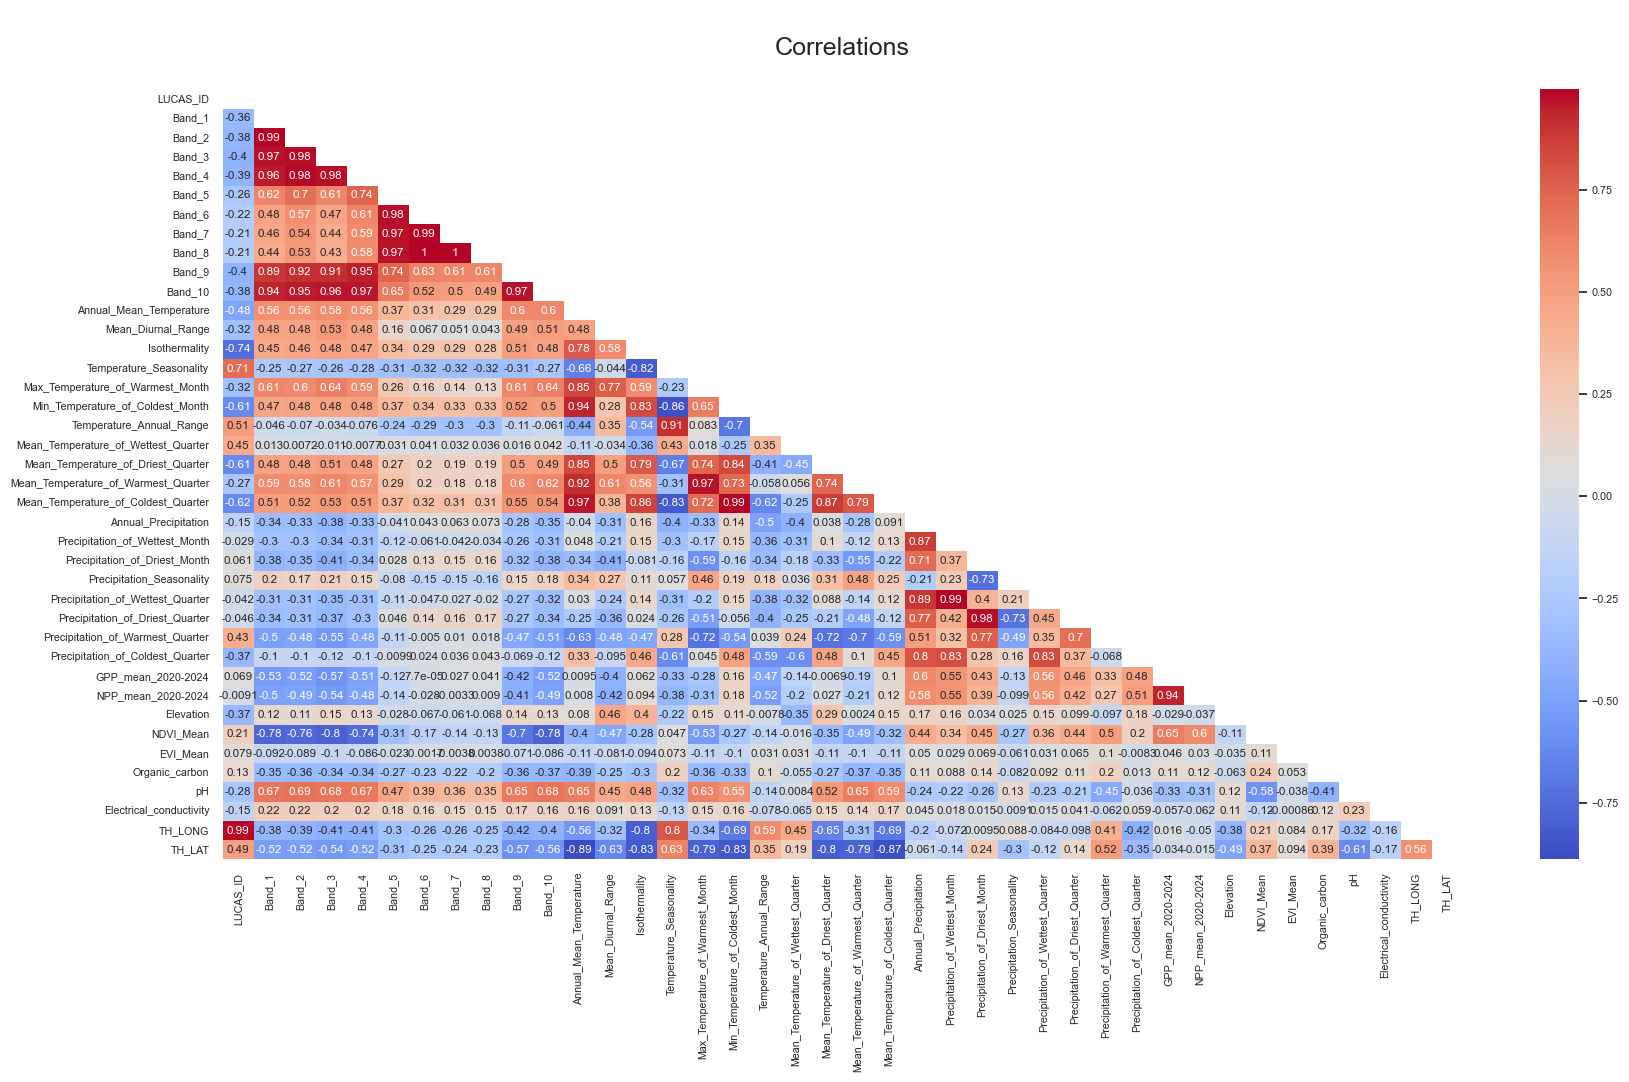

In [14]:
half_masked_corr_heatmap(df,
                         figsize=(20,10),
                         title='Correlations',
                         )

In [15]:
# Examine Land use distribution
df.LC_simpl_2018.value_counts()

LC_simpl_2018
Cropland     335
Woodland     271
Grassland    150
Shrubland     28
Bareland      26
Others         4
Wetland        1
Name: count, dtype: int64

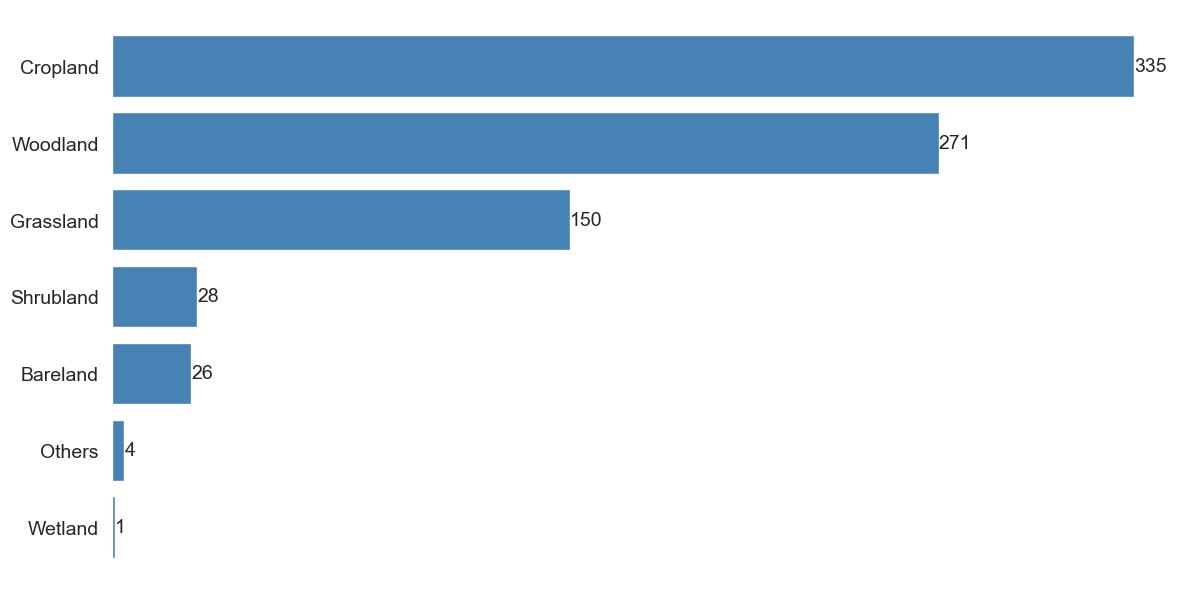

In [16]:
plt.figure(figsize=(12, 6))

# Get value counts
lc_counts = df.LC_simpl_2018.value_counts(ascending=True)

# Create horizontal bar plot
bars = plt.barh(range(len(lc_counts)), lc_counts.values, color='steelblue')
plt.yticks(range(len(lc_counts)), lc_counts.index, fontsize=14)

# Add value labels at the end of each bar
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2,
             f'{int(width):,}',
             ha='left', va='center', fontsize=14)

# Remove x-axis
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Remove borders
plt.box(False)

# Adjust layout and show
plt.tight_layout()
plt.savefig('outputs/plots/land_cover.png', dpi=500, bbox_inches='tight')
plt.show()


In [17]:
# remove wetlands because only 1 example wouldn't work for stratified splitting. 
df = df[df.LC_simpl_2018 != 'Wetland']

## Random Forest and XGBoost Modeling

In [18]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from skopt import BayesSearchCV

In [19]:
# Create an empty DataFrame to store model results
results_df = pd.DataFrame(columns=['Model', 'R2', 'RMSE', 'Hyperparameters'])

# Define function to split data
def split_data(X,y, test_size=0.2, random_state=42):
    # Split and scale data
    if 'LC_simpl_2018' in X.columns.tolist():
        # Encode the categorical column
        label_encoder = LabelEncoder()
        X['LC_simpl_2018'] = label_encoder.fit_transform(X['LC_simpl_2018'])
        # Stratify split using landcover information
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                            random_state=random_state, stratify=X['LC_simpl_2018'])
        # drop land cover columns
        X_train = X_train.drop('LC_simpl_2018', axis=1)
        X_test = X_test.drop('LC_simpl_2018', axis=1)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                            random_state=random_state)
    return X_train, X_test, y_train, y_test

# Define function to scale data
def scale_data(scaler, X_train, X_test):
    scaler = scaler
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled


# Define function to evaluate model and store results
def evaluate_model(model_name, y_true, y_pred, hyperparameters):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    results_df.loc[len(results_df)] = [model_name, r2, rmse, hyperparameters]

# Train and evaluate Random Forest model
def train_evaluate_rf(X_train, X_test, y_train, y_test, best_params):
    rf = RandomForestRegressor(**best_params)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    evaluate_model('Random Forest', y_test, y_pred, best_params)
    return pd.DataFrame({'Actual': y_test, 'RF_Predicted': y_pred})



# Train and evaluate XGBoost model
def train_evaluate_xgb(X_train, X_test, y_train, y_test, best_params):
    xgb = XGBRegressor(**best_params)
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    evaluate_model('XGBoost', y_test, y_pred, best_params)
    return pd.DataFrame({'Actual': y_test, 'XGB_Predicted': y_pred})

# Hyperparameter grid for Random Forest
rf_param_grid = {
        'n_estimators': [50, 100, 150],
        'max_features': ['sqrt', 'log2'],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
# Hyperparameter grid for XGBoost
xgb_param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.02, 0.05],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.7, 0.8],
    'reg_alpha': [1, 3, 5],
    'reg_lambda': [1, 3, 5]
}

### pH

In [20]:
# Initialize models
rf_model = RandomForestRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42)

# Setup X and y variable(s)
X = df.drop(['LUCAS_ID','pH'], axis=1)

pH_y = df['pH']

# split data into test and train
pH_train_data, pH_test_data, pH_y_train, pH_y_test = split_data(X,pH_y)

# Perform hyperparameter optimization for RF model for pH prediction
bayes_search_rf_pH = BayesSearchCV(rf_model, rf_param_grid, n_iter=10, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
bayes_search_rf_pH.fit(pH_train_data, pH_y_train) 

# Perform hyperparameter optimization for XGB model for pH prediction
bayes_search_xgb_pH = BayesSearchCV(xgb_model, xgb_param_grid, n_iter=10, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
bayes_search_xgb_pH.fit(pH_train_data, pH_y_train)


# Train and evaluate models
rf_pH = train_evaluate_rf(pH_train_data, pH_test_data, pH_y_train, pH_y_test, bayes_search_rf_pH.best_params_)
xgb_pH = train_evaluate_xgb(pH_train_data, pH_test_data, pH_y_train, pH_y_test, bayes_search_xgb_pH.best_params_)

# Display and save results
print(results_df)

           Model        R2      RMSE  \
0  Random Forest  0.720128  0.721814   
1        XGBoost  0.800630  0.609221   

                                     Hyperparameters  
0  {'max_depth': 20, 'max_features': 'log2', 'min...  
1  {'learning_rate': 0.02, 'max_depth': 5, 'n_est...  


### Script to generate and save regression plots for different models

In [21]:
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define function to calculate RPIQ
def RPIQ(y_true, y_pred):
    q3 = np.percentile(y_true, 75)
    q1 = np.percentile(y_true, 25)
    return (q3 - q1) / np.sqrt(mean_squared_error(y_true, y_pred))

def plot_regression(test_y, y_pred, model_name, filename=None):
    
    # Create plot
    fig, ax = plt.subplots(figsize=(6, 5))

    ax.set_facecolor('none')  # Transparent background
    # Keep grid but make it lighter and not overpowering
    ax.grid(True, linestyle='-', alpha=0.7, color='lightgray')

    for spine in ax.spines.values():
        spine.set_color('lightgray')
        spine.set_linewidth(1.0)
    
    # Create a custom colormap
    custom_colors = ['#000375', '#D9444D', '#F5E8C5']
    cmap = LinearSegmentedColormap.from_list('custom_cmap', custom_colors, N=200)

    # Create the scatter plot
    ax_ = ax.scatter(test_y, y_pred, s=20)

    # Add least squares regression line
    sns.regplot(x=test_y, y=y_pred, scatter=False, line_kws={'color':'#27847A', 'linewidth':2}, ax=ax)

    # Add 1:1 line
    ax.plot(test_y, test_y, linestyle='--', color='black')

    # Set font to Computer Modern Serif
    plt.rcParams['font.family'] = 'serif'

    # Add labels and title with updated font sizes
    plt.xlabel('Observed', fontsize=22)
    plt.ylabel('Predicted', fontsize=22)
    plt.title(model_name, fontsize=22)

    # Calculate and add R2, RMSE, and RPIQ annotations
    r2 = r2_score(test_y, y_pred)
    rmse = np.sqrt(mean_squared_error(test_y, y_pred))
    rpiq = RPIQ(test_y, y_pred)
    ax.text(ax.get_xlim()[0] + 0.05 * (ax.get_xlim()[1] - ax.get_xlim()[0]),
            ax.get_ylim()[1] - 0.01 * (ax.get_ylim()[1] - ax.get_ylim()[0]),
            f'\nR$^2$: {r2:.2f}\nRMSE: {rmse:.2f}\nRPIQ: {rpiq:.2f}',
            verticalalignment='top', horizontalalignment='left', fontsize=16, style='italic', fontname='serif')

    # Set y-axis tick formatter to remove decimals
    # ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))

    # Adjust y-axis ticks to have a step of 1
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)

    # Remove frame around the plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Save the plot if filename is provided
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')

    # Show the plot
    plt.tight_layout()
  

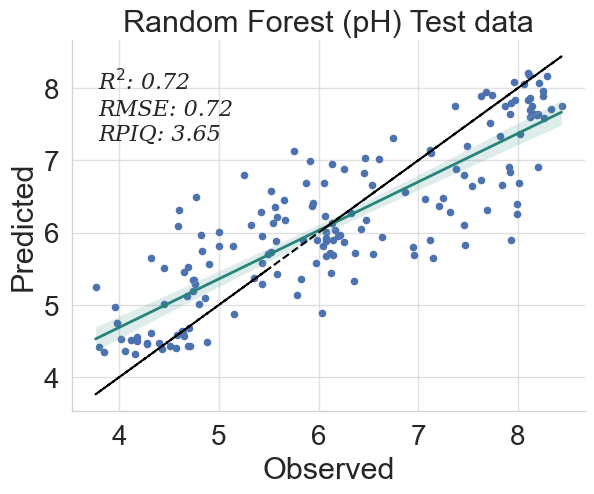

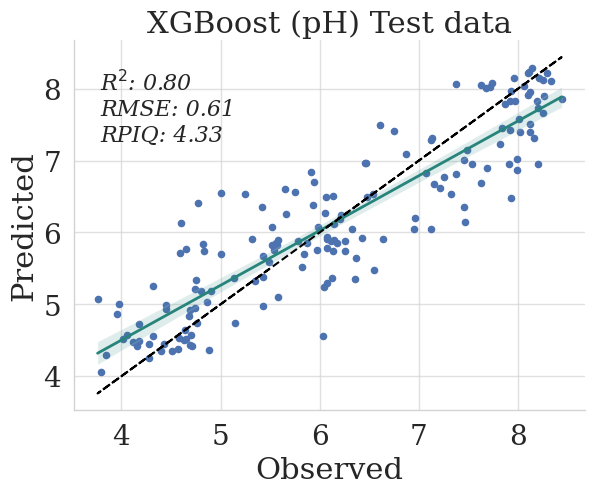

In [22]:
#  Example usage and saving plots
plot_regression(rf_pH.Actual.values, 
			   rf_pH.RF_Predicted.values, 
			   "Random Forest (pH) Test data", 
			   "outputs/plots/pH_random_forest_plot.png")

plot_regression(xgb_pH.Actual.values, 
			   xgb_pH.XGB_Predicted.values, 
			   "XGBoost (pH) Test data", 
			   "outputs/plots/pH_xgboost_plot.png")

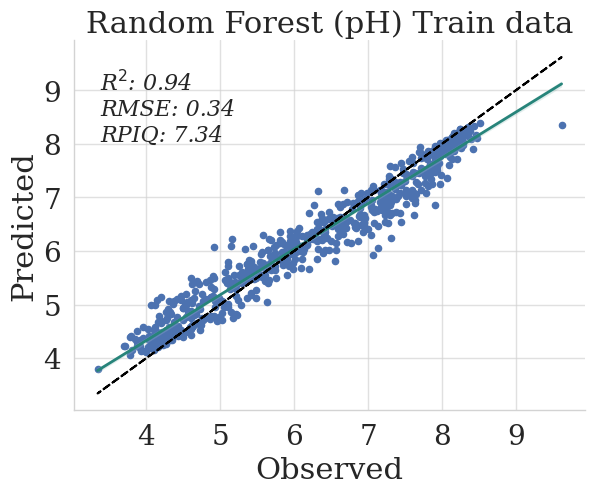

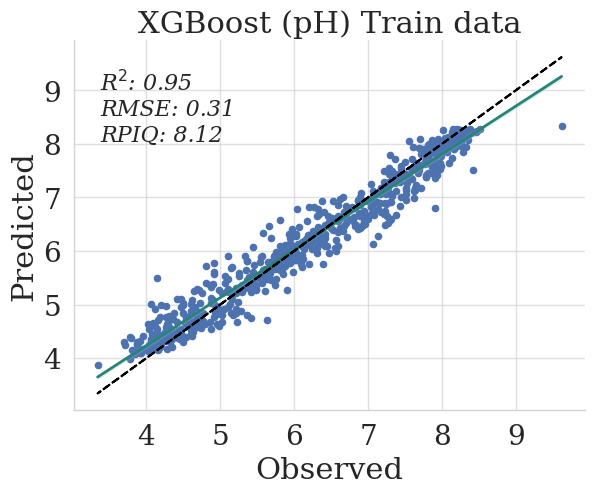

In [ ]:
# Get predictions for training data
xgb_train_predictions = bayes_search_xgb_pH.best_estimator_.predict(pH_train_data)
rf_train_predictions = bayes_search_rf_pH.best_estimator_.predict(pH_train_data)
train_actual = pH_y_train.values

#  Example usage and saving plots
plot_regression(train_actual, 
			   rf_train_predictions, 
			   "Random Forest (pH) Train data", 
			   "outputs/plots/ph_train_random_forest_plot.png")

plot_regression(train_actual, 
			   xgb_train_predictions, 
			   "XGBoost (pH) Train data", 
			   "outputs/plots/ph_train_xgboost_plot.png")

---
## Spatial distribution of estimators

In [24]:
# Merge the dataframes based on band columns
pH_test_with_cords = pd.merge(pH_test_data[BAND_COLS], 
                 df[BAND_COLS + ['LUCAS_ID', 'TH_LAT', 'TH_LONG']],
                 on=BAND_COLS,
                 how='inner')

# Show the results
print("Found matching rows:", len(pH_test_with_cords))
pH_test_with_cords.head()

Found matching rows: 163


,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_9,Band_10,LUCAS_ID,TH_LAT,TH_LONG
0,263,551,365,907,2713,3388,3609,3723,1794,892,43363356,53.311844,10.225026
1,511,812,1099,1270,1729,1894,2008,2024,2225,1636,33581994,40.393017,-1.334395
2,706,1120,1694,1988,2473,2693,2772,2933,3386,2515,32062178,41.807550,-3.447625
3,224,397,367,740,1656,1975,2031,2211,1390,784,55462186,41.693402,24.765031
4,591,853,956,1287,2209,2542,2616,2805,2483,1935,51343172,51.074026,21.656833


In [25]:
# Add observed pH values to pH_test_with_cords
pH_test_with_cords[['observed_ph', 'rf_predicted_ph']] = rf_pH[['Actual', 'RF_Predicted']].values
pH_test_with_cords['xgb_predicted_ph'] = xgb_pH['XGB_Predicted'].values
# Calculate prediction errors
pH_test_with_cords['rf_error'] = pH_test_with_cords['rf_predicted_ph'] - pH_test_with_cords['observed_ph']
pH_test_with_cords['xgb_error'] = pH_test_with_cords['xgb_predicted_ph'] - pH_test_with_cords['observed_ph']

pH_test_with_cords.head(2)

,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_9,Band_10,LUCAS_ID,TH_LAT,TH_LONG,observed_ph,rf_predicted_ph,xgb_predicted_ph,rf_error,xgb_error
0,263,551,365,907,2713,3388,3609,3723,1794,892,43363356,53.311844,10.225026,6.06,6.228714,6.495270,0.168714,0.435270
1,511,812,1099,1270,1729,1894,2008,2024,2225,1636,33581994,40.393017,-1.334395,7.37,7.750807,8.061138,0.380807,0.691138


In [26]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

def plot_prediction_errors(df, error, filename, title='Prediction Error (Predicted – Observed)'):
    """
    Create a map visualization of prediction errors with sized points.
    
    Args:
        df (pd.DataFrame): DataFrame containing columns 'TH_LONG', 'TH_LAT', 
                          'predicted_ph', and 'observed_ph'
        error (str): Column name 
        filename (str): Path where the plot should be saved
        title (str): Title for the plot
    """
    # Create figure and axis with cartopy projection
    fig = plt.figure(figsize=(10, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Set background to white
    ax.set_facecolor('white')

    # Add map features
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Set map extent based on data
    margin = 2  # degrees of margin around data points
    ax.set_extent([
        df['TH_LONG'].min() - margin,
        df['TH_LONG'].max() + margin,
        df['TH_LAT'].min() - margin,
        df['TH_LAT'].max() + margin
    ], crs=ccrs.PlateCarree())

    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linestyle='--', color='lightgray')
    gl.top_labels = False
    gl.right_labels = False

    # Separate overestimated and underestimated points
    over = df[error] > 0
    under = df[error] <= 0

    # Define error size bins
    sizes_dict = {0.25: 20, 0.50: 50, 0.75: 75, 1.00: 100, 1.50: 150}

    # Categorize errors by magnitude for sizing
    def get_size(error_val):
        abs_error = abs(error_val)
        if abs_error <= 0.25: return sizes_dict[0.25]
        elif abs_error <= 0.50: return sizes_dict[0.50]
        elif abs_error <= 0.75: return sizes_dict[0.75]
        elif abs_error <= 1.00: return sizes_dict[1.00]
        else: return sizes_dict[1.50]

    # Apply the size function
    point_sizes = df[error].apply(get_size)

    # Plot points
    plt.scatter(df.loc[over, 'TH_LONG'], df.loc[over, 'TH_LAT'],
               c='navy', s=point_sizes[over], alpha=0.7, edgecolors='none')
    plt.scatter(df.loc[under, 'TH_LONG'], df.loc[under, 'TH_LAT'],
               c='firebrick', s=point_sizes[under], alpha=0.7, edgecolors='none')

    # Create legend elements with all items
    legend_elements = [
    # First column - Over/Under estimation
    Line2D([0], [0], marker='o', color='w', markerfacecolor='navy',
           markersize=10, label='Overestimated'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='firebrick',
           markersize=10, label='Underestimated'),
    # Second column - Size markers
    *[Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
           markersize=np.sqrt(sizes_dict[size_key]), 
           label=f'{size_key:.2f}')
      for size_key in [0.25, 0.50, 0.75, 1.00]],
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
           markersize=np.sqrt(sizes_dict[1.50]), label='>1.50')
    ]

    # Add legend with 2 columns
    ax.legend(handles=legend_elements, loc='upper left',
         frameon=True, framealpha=0.8, facecolor='white',
         labelspacing=0.2, ncol=1, columnspacing=1.0)

    # Set labels
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(title, fontsize=20)

    # Add border
    for spine in ax.spines.values():
        spine.set_visible(True)

    plt.savefig(filename, dpi=600, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

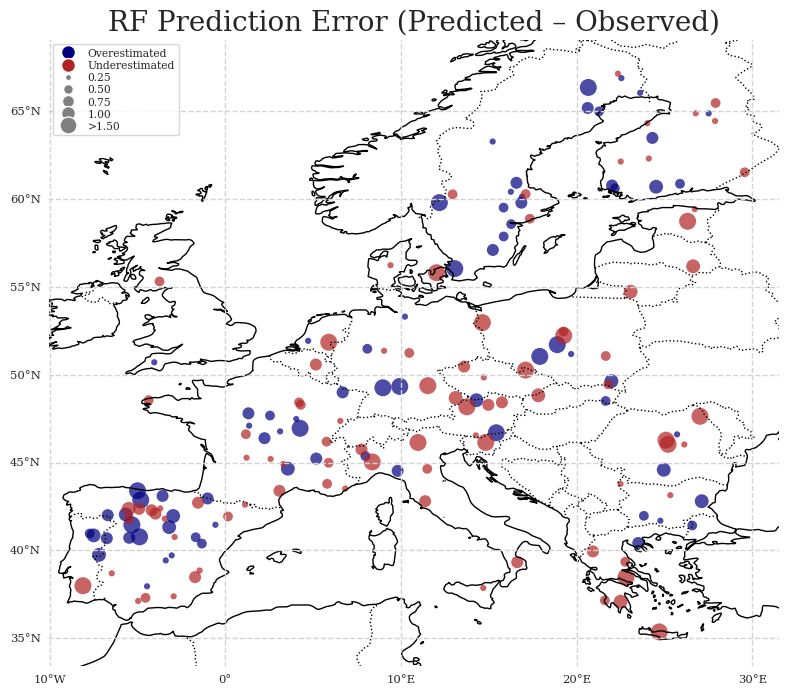

In [27]:
plot_prediction_errors(pH_test_with_cords,
                       'rf_error',
                      'outputs/plots/rf_errors.png',
                      'RF Prediction Error (Predicted – Observed)')

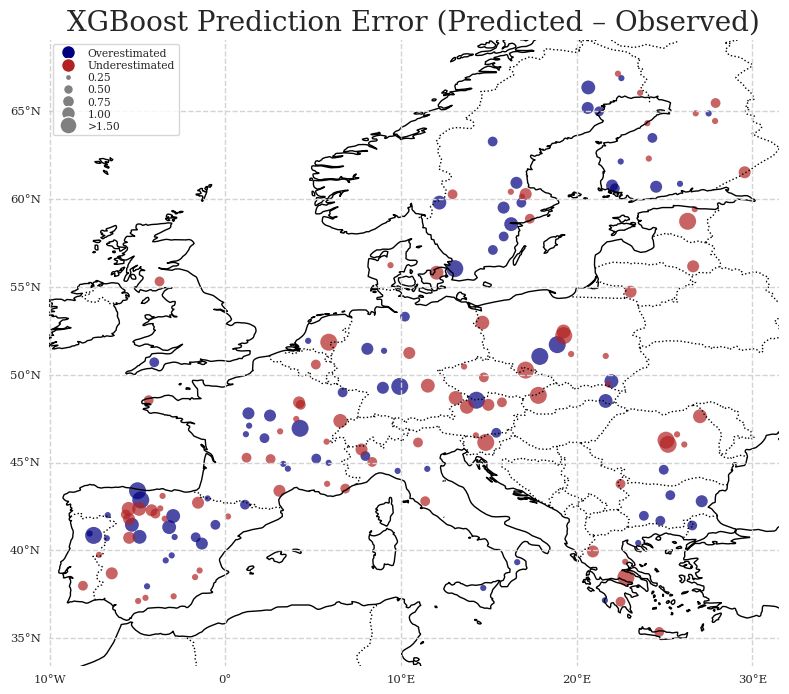

In [28]:
plot_prediction_errors(pH_test_with_cords,
                       'xgb_error',
                      'outputs/plots/xgb_errors.png',
                      'XGBoost Prediction Error (Predicted – Observed)')

---

## Estimation bias by pH category

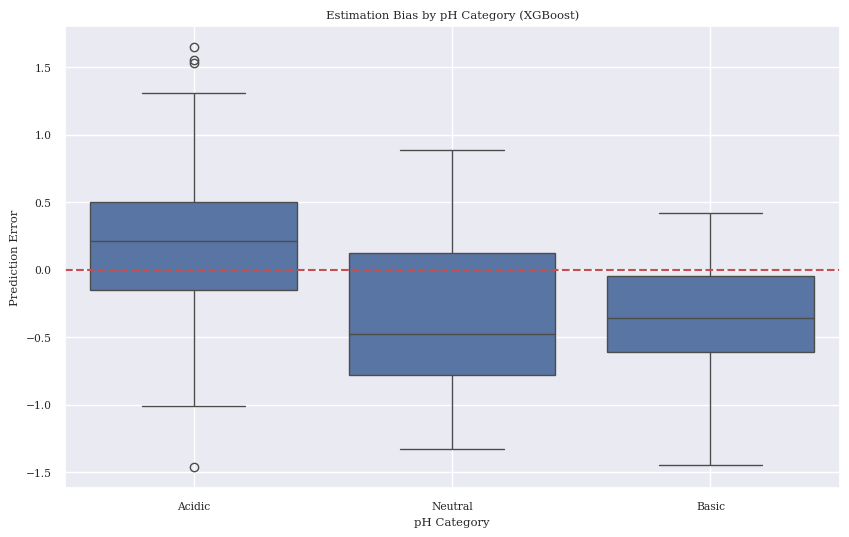

,mean,count,std
ph_category,,,
Acidic,0.198062,101,0.564655
Neutral,-0.370032,22,0.623660
Basic,-0.356855,40,0.463480


In [29]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_ph_estimation_bias(data, predicted_value, actual_value, title):
    # Calculate estimation error
    data['error'] = data[predicted_value] - data[actual_value]
    
    # Categorize pH values
    data['ph_category'] = pd.cut(data[actual_value], 
                                bins=[0, 6.5, 7.5, 14],
                                labels=['Acidic', 'Neutral', 'Basic'])
    
    # Calculate mean error for each pH category
    ph_bias = data.groupby('ph_category')['error'].agg(['mean', 'count', 'std'])
    
    # Visualization
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='ph_category', y='error', data=data)
    plt.title(f'Estimation Bias by pH Category ({title})')
    plt.xlabel('pH Category')
    plt.ylabel('Prediction Error')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.grid(True)
    plt.show()
    
    return ph_bias

# Example usage:

analyze_ph_estimation_bias(pH_test_with_cords,
                       'xgb_predicted_ph',
                      'observed_ph',
                      'XGBoost')

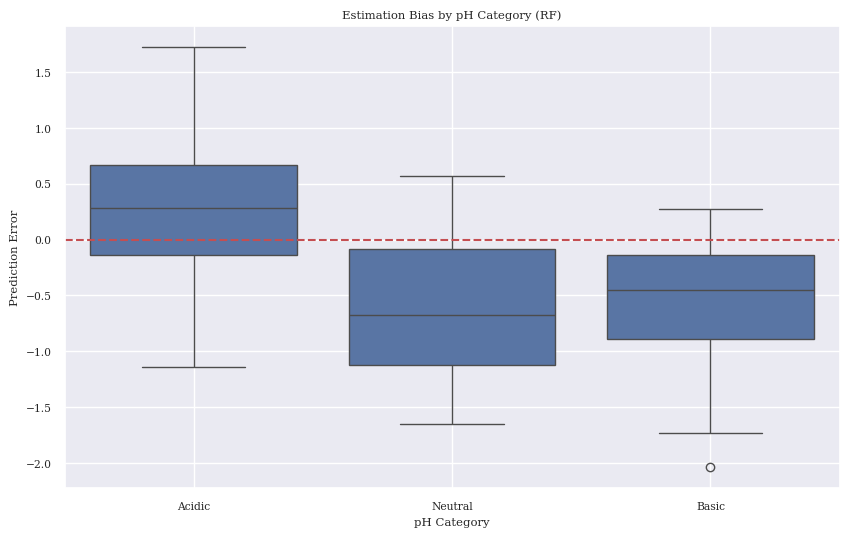

,mean,count,std
ph_category,,,
Acidic,0.302643,101,0.588081
Neutral,-0.601010,22,0.646204
Basic,-0.543832,40,0.567150


In [30]:
analyze_ph_estimation_bias(pH_test_with_cords,
                       'rf_predicted_ph',
                      'observed_ph',
                      'RF')

---

## SHAP Analysis

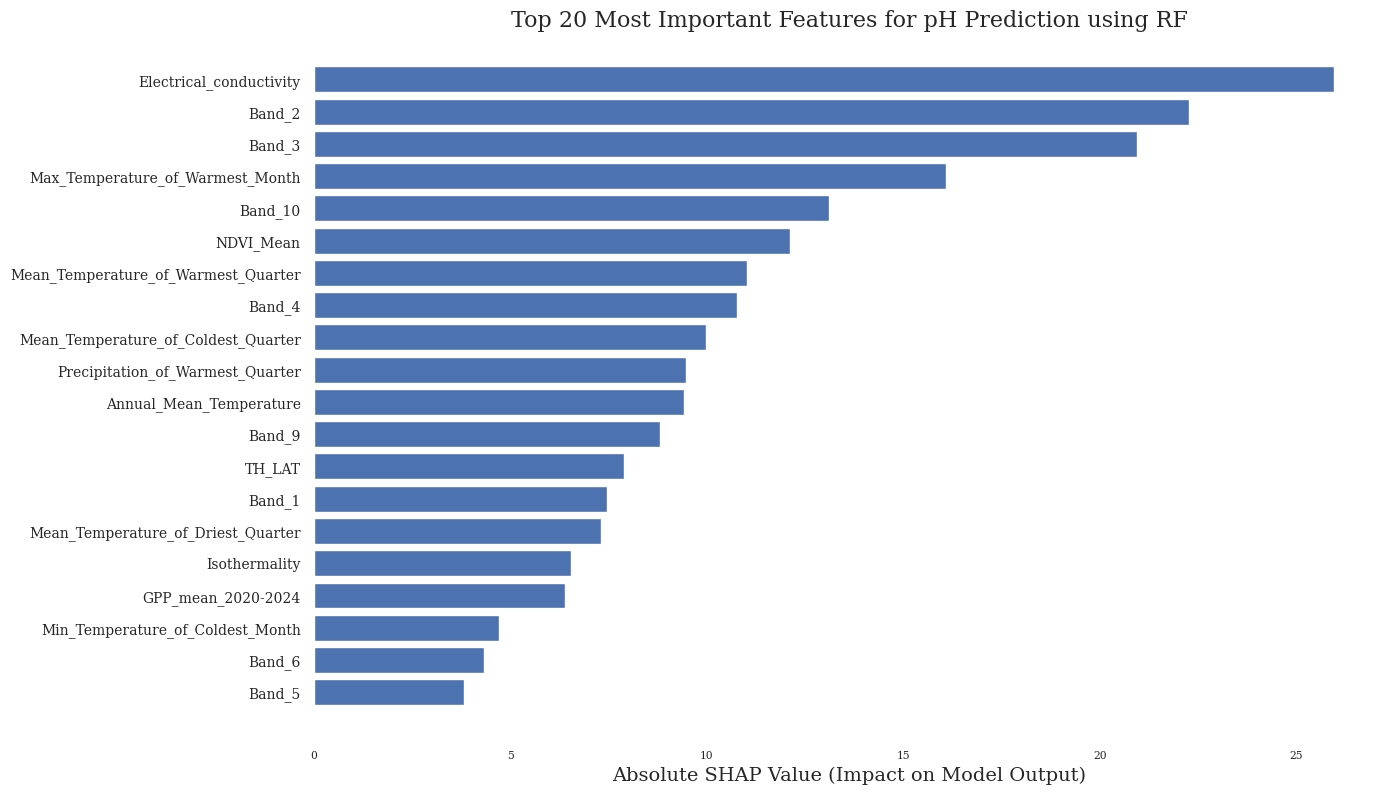

In [31]:
## SHAP
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initialize the SHAP explainer with the Random Forest model
rf_explainer = shap.TreeExplainer(bayes_search_rf_pH.best_estimator_)

# Compute Shapley values for the test dataset
shap_values = rf_explainer.shap_values(pH_test_data)

# Calculate absolute Shapley values
absolute_shap_values = np.abs(shap_values)

# Sum absolute Shapley values over all observations to obtain overall variable contribution
variable_contribution = np.sum(absolute_shap_values, axis=0)

# Create a DataFrame for better visualization
contribution_df = pd.DataFrame({
    'Feature': pH_test_data.columns,
    'Absolute Contribution': variable_contribution
})

# Sort by Absolute Contribution
contribution_df = contribution_df.sort_values(by='Absolute Contribution', ascending=False)

# Select the top 20 features
top_20_df = contribution_df.head(20)
top_20_df_sorted = top_20_df.sort_values('Absolute Contribution', ascending=True)

# Create figure with specified size
plt.figure(figsize=(14, 8))
plt.grid(True)
plt.gca().set_facecolor('white')

# Create the horizontal bar plot
plt.barh(np.arange(len(top_20_df_sorted)), top_20_df_sorted['Absolute Contribution'],)

# Customize the plot
plt.xlabel('Absolute SHAP Value (Impact on Model Output)', fontsize=14)
plt.title('Top 20 Most Important Features for pH Prediction using RF', fontsize=16)
plt.yticks(np.arange(len(top_20_df_sorted)), top_20_df_sorted['Feature'], fontsize=10)

# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig('outputs/plots/rf_ph_shapley_importance.png', dpi=500, bbox_inches='tight')

plt.show()


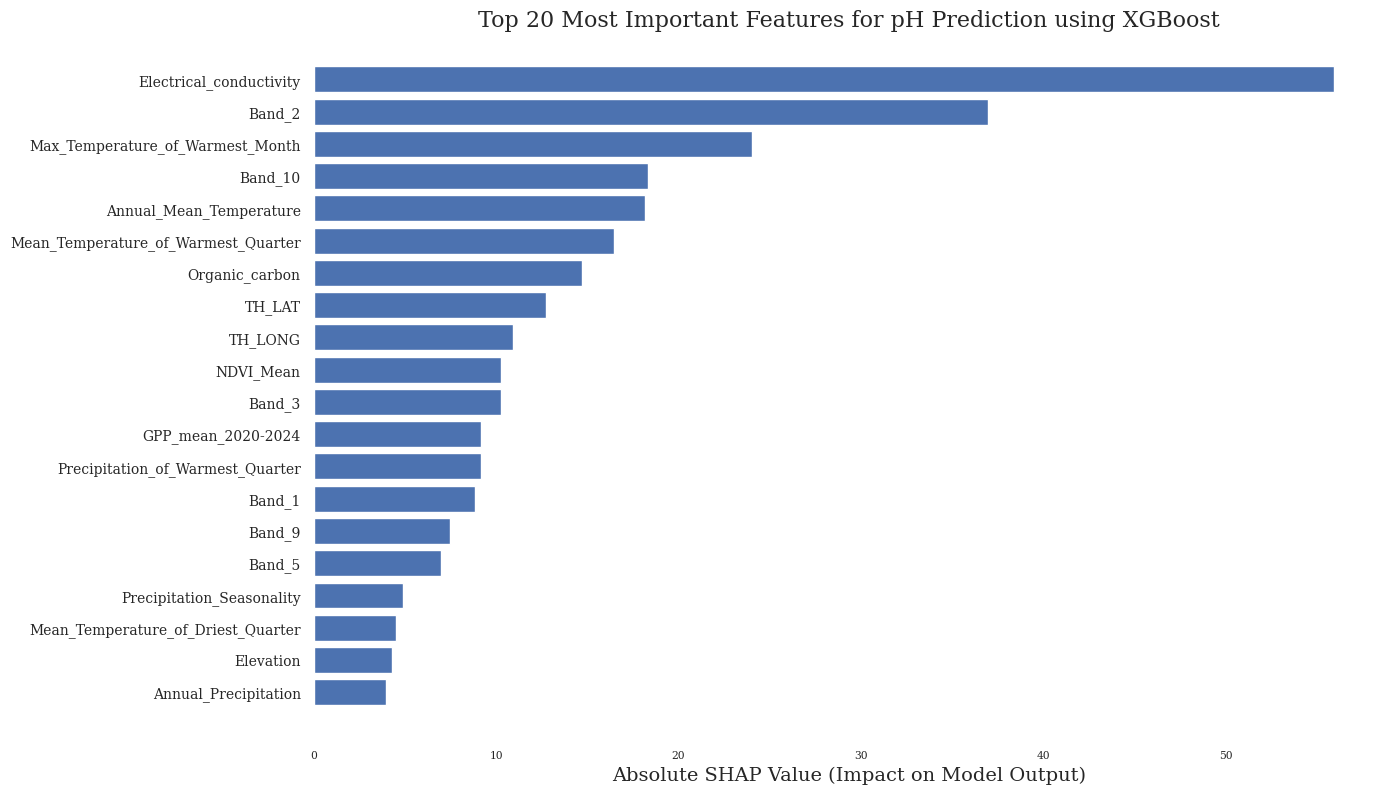

In [32]:
## SHAP
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initialize the SHAP explainer with the Random Forest model
xgb_explainer = shap.TreeExplainer(bayes_search_xgb_pH.best_estimator_)

# Compute Shapley values for the test dataset
shap_values = xgb_explainer.shap_values(pH_test_data)

# Calculate absolute Shapley values
absolute_shap_values = np.abs(shap_values)

# Sum absolute Shapley values over all observations to obtain overall variable contribution
variable_contribution = np.sum(absolute_shap_values, axis=0)

# Create a DataFrame for better visualization
contribution_df = pd.DataFrame({
    'Feature': pH_test_data.columns,
    'Absolute Contribution': variable_contribution
})

# Sort by Absolute Contribution
contribution_df = contribution_df.sort_values(by='Absolute Contribution', ascending=False)

# Select the top 20 features
top_20_df = contribution_df.head(20)
top_20_df_sorted = top_20_df.sort_values('Absolute Contribution', ascending=True)

# Create figure with specified size
plt.figure(figsize=(14, 8))
plt.grid(True)
plt.gca().set_facecolor('white')

# Create the horizontal bar plot
plt.barh(np.arange(len(top_20_df_sorted)), top_20_df_sorted['Absolute Contribution'],)

# Customize the plot
plt.xlabel('Absolute SHAP Value (Impact on Model Output)', fontsize=14)
plt.title('Top 20 Most Important Features for pH Prediction using XGBoost', fontsize=16)
plt.yticks(np.arange(len(top_20_df_sorted)), top_20_df_sorted['Feature'], fontsize=10)

# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig('outputs/plots/xgb_ph_shapley_importance.png', dpi=500, bbox_inches='tight')

plt.show()

### Partial dependence plot using Shapley values against a single covariate (XGBoost model).

In [34]:
pH_test_with_cords

,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_9,Band_10,LUCAS_ID,TH_LAT,TH_LONG,observed_ph,rf_predicted_ph,xgb_predicted_ph,rf_error,xgb_error,error,ph_category
0,263,551,365,907,2713,3388,3609,3723,1794,892,43363356,53.311844,10.225026,6.06,6.228714,6.495270,0.168714,0.435270,0.168714,Acidic
1,511,812,1099,1270,1729,1894,2008,2024,2225,1636,33581994,40.393017,-1.334395,7.37,7.750807,8.061138,0.380807,0.691138,0.380807,Neutral
2,706,1120,1694,1988,2473,2693,2772,2933,3386,2515,32062178,41.807550,-3.447625,7.97,7.840307,7.834730,-0.129693,-0.135270,-0.129693,Basic
3,224,397,367,740,1656,1975,2031,2211,1390,784,55462186,41.693402,24.765031,4.80,5.017394,5.186403,0.217394,0.386403,0.217394,Acidic
4,591,853,956,1287,2209,2542,2616,2805,2483,1935,51343172,51.074026,21.656833,5.97,5.585277,5.760301,-0.384723,-0.209699,-0.384723,Acidic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,167,278,236,486,1290,1576,1593,1772,880,468,43962560,46.148646,10.969678,7.15,5.641657,6.674284,-1.508343,-0.475716,-1.508343,Neutral
159,687,1132,1600,1936,2546,2781,2848,2975,3298,2432,30302240,42.050451,-5.666318,6.13,6.951362,5.741713,0.821362,-0.388287,0.821362,Acidic
160,760,1121,1290,1680,2783,3183,3257,3414,2590,1975,49483302,52.467754,19.254728,6.07,5.681828,5.292097,-0.388172,-0.777903,-0.388172,Acidic
161,272,481,466,946,2304,2732,2824,3090,1892,983,46784220,60.931181,16.573779,4.75,5.337118,5.335845,0.587118,0.585845,0.587118,Acidic


In [ ]:
# Get the first two rows with smallest error
pH_test_with_cords['abs_xgb_error'] = pH_test_with_cords['xgb_error'].abs()
smallest_errors = pH_test_with_cords.nsmallest(2, 'abs_xgb_error')

# Display the results
print("Two points with smallest XGBoost prediction error: ", smallest_errors.index.values)

Two points with smallest XGBoost prediction error:  [129, 7]


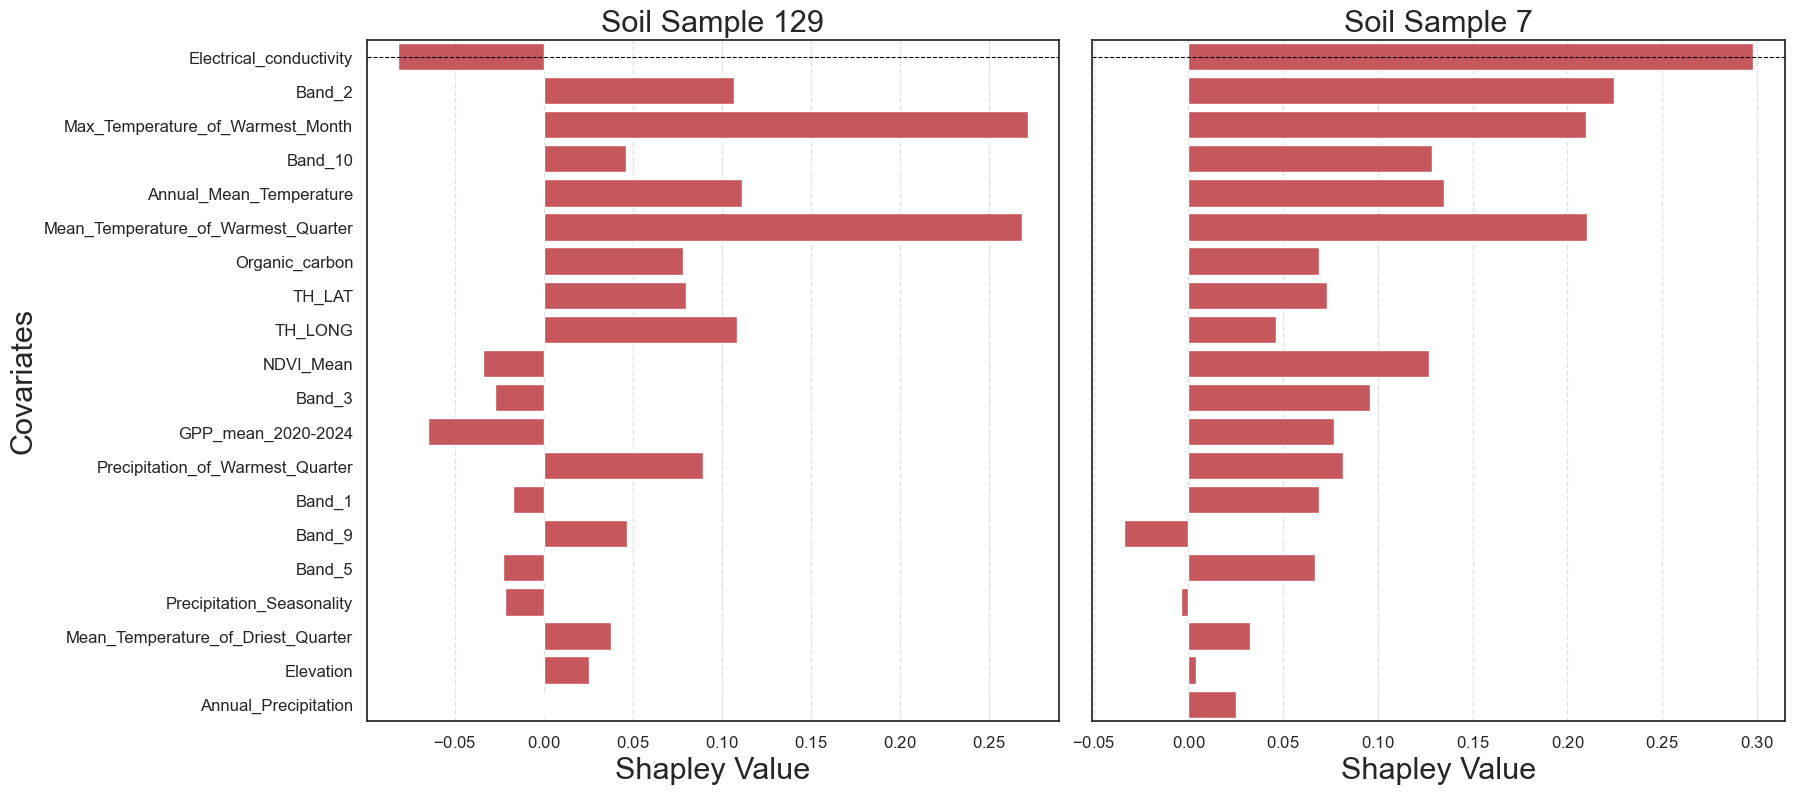

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Identify the top 20 features based on absolute mean Shapley values
top_feature_indices = np.argsort(np.abs(shap_values).mean(axis=0))[::-1][:20]
feature_names = pH_test_data.columns.tolist()
top_feature_names = [feature_names[i] for i in top_feature_indices]

# Create a list for renamed features based on your specifications
renamed_top_feature_names = top_feature_names.copy()

# Specify the indices for the samples to plot
specific_indices = smallest_errors.index.values

sns.set_style("white") 

# Set up the figure for side-by-side comparison
plt.figure(figsize=(18, 8))

# Create subplots for each selected point
for i, index in enumerate(specific_indices):
    # Get Shapley values for the current point and filter for top features
    shap_values_point = shap_values[index, top_feature_indices]
    
    # Define colors based on the Shapley values (positive: red)
    colors = np.where(shap_values_point > 0, "#D9444D", "#D9444D")
    
    # Plot the Shapley values for the current point
    plt.subplot(1, 2, i + 1)  # Create two side-by-side plots
    sns.barplot(y=renamed_top_feature_names, x=shap_values_point, palette=colors)

    # Set labels, grid, and title for the plot
    plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
    plt.grid(axis='x', linestyle='--', alpha=0.6)  # Add a grid along the x-axis
    plt.title(f'Soil Sample {index}', fontsize=22)
    plt.xlabel('Shapley Value', fontsize=22)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.gca().xaxis.get_major_formatter().set_useMathText(True)

    # Remove the y-axis label for the second plot
    if i == 0:
        plt.ylabel('Covariates', fontsize=22)  # Keep the y-axis label for the first plot
    else:
        plt.ylabel(None)  # Remove the y-axis label for the second plot
        plt.yticks([])  # Remove y-ticks for the second plot
        
# Adjust layout for better visualization
plt.tight_layout()

# Save the plot as a PNG image
output_file = "outputs/plots/shapley_contributions_two_points_plot.png"
os.makedirs(os.path.dirname(output_file), exist_ok=True)
plt.savefig(output_file, dpi=600, bbox_inches='tight')

# Show the plot
plt.show()


---